# PART 2
### Time-Series Analysis

Let's pick up where we left off, starting by importing a few necessary libraries/packages/modules

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import matplotlib.ticker as ticker
import math
from warnings import simplefilter
simplefilter("ignore")

Kaggle provides a few bits of code to set up my plots and there are a few functions I've used from their lessons on Time-Series Analysis which will be useful for visualization.  Some they borrowed from stackexchange it looks like.

In [2]:
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [3]:
# # Kaggle notebook version of reading in the daata
# data = pd.read_csv('../input/sales-forecasting/train.csv')

We'll start with the same series of steps to prep the data for analysis that we did previously.  We'll add a time counter and a Lag right off the bat, but we'll dig more into those in a moment.

In [4]:
# Personal notebook version of reading in the daata
data = pd.read_csv('Assets/train.csv')

In [5]:
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

In [6]:
data.set_index('Order Date', inplace=True)

In [7]:
sales = data[['Sales']]
sales = sales.groupby('Order Date').sum()
sales.rename(columns={'Sales':'TotalSales'}, inplace=True)
sales['Time'] = np.arange(len(sales.index))
sales['Lag_1'] = sales['TotalSales'].shift(1)
sales.head()

,TotalSales,Time,Lag_1
Order Date,,,
2015-01-03,16.448,0,NaN
2015-01-04,288.060,1,16.448
2015-01-05,19.536,2,288.060
2015-01-06,4407.100,3,19.536
2015-01-07,87.158,4,4407.100


Let's start by taking a look at the data in full:

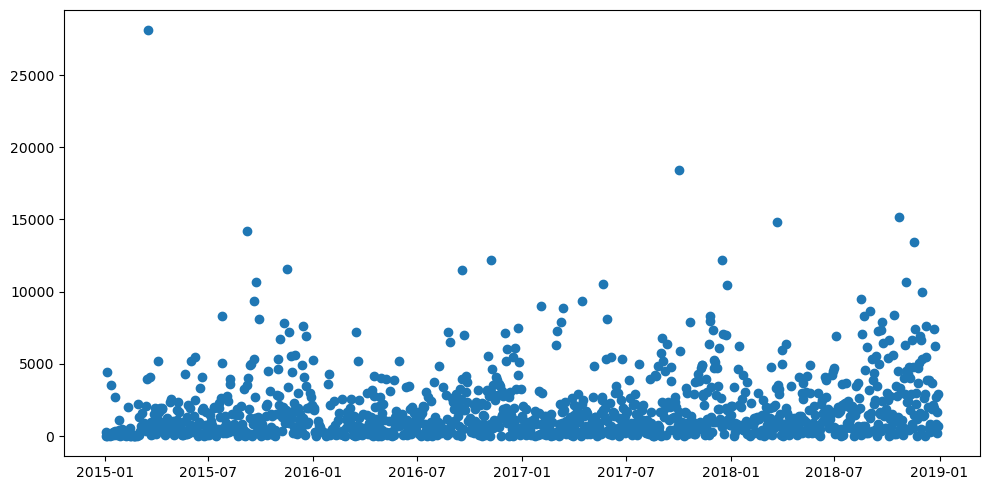

In [8]:
fig = plt.figure(figsize = (10,5))
plt.scatter(x=sales.index, y=sales['TotalSales']);

This is a bit messy, so we can focus on the first 25 datapoints, just to get a sense of the data.

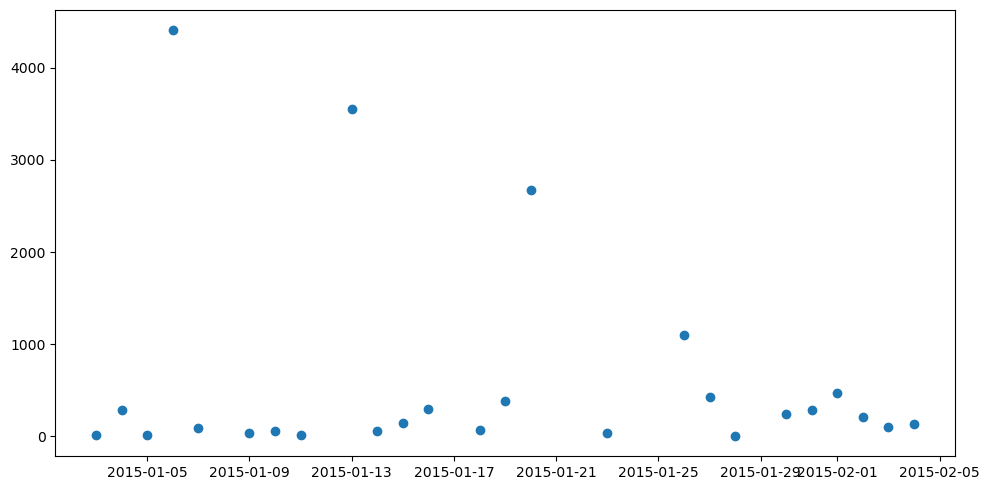

In [9]:
plt.figure(figsize = (10,5))
plt.scatter(x=sales.index[0:25], y=sales.iloc[0:25,0]);

Let's look at the trend over time of the data.  We can do this a number of ways-- LinearRegression is one way to start.  I've added sum the roots of the squared differences for reference.

In [10]:
from sklearn.linear_model import LinearRegression

X = sales.loc[:, ['Time']]
y = sales.loc[:, 'TotalSales']

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
print("RMSE:",int(math.sqrt((abs(y - y_pred)**2).sum())/X.shape[0]))

RMSE: 64


Plotting this shows the trendline.

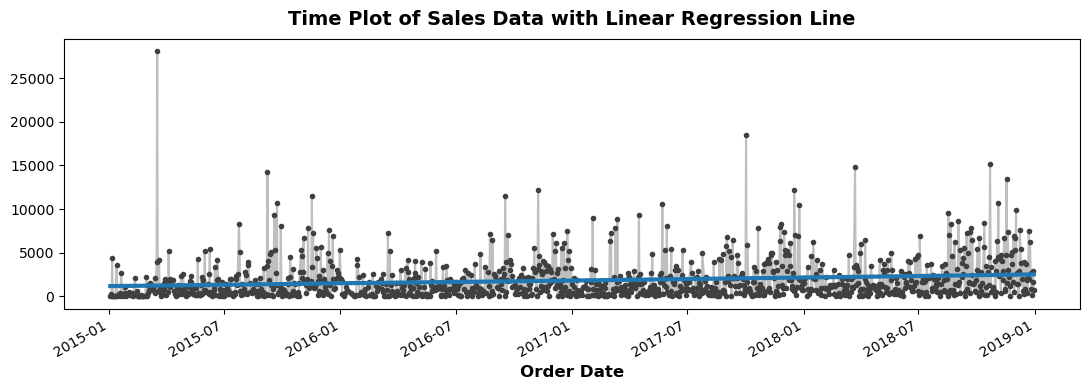

In [11]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Sales Data with Linear Regression Line');

Instead of looking at the trend as it relates to the sequential time, we can also look at the trend from the 1-shift lag.

In [12]:
X = sales[['Lag_1']].copy()
X.dropna(inplace=True)
y = sales.loc[:, 'TotalSales']
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
print("RMSE:",int(math.sqrt((abs(y - y_pred)**2).sum())/X.shape[0]))

RMSE: 65


This one doens't match up quite as well.  I was mostly curious.  We can visualize it too.

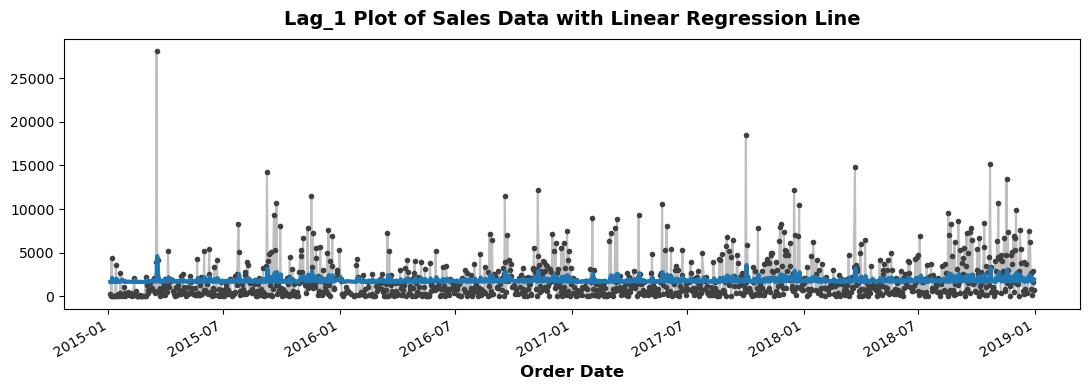

In [13]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Lag_1 Plot of Sales Data with Linear Regression Line');

Let's also plot this one-step lag against Sales.  It doesn't show much correlation, as we'll look at in more detail soon.

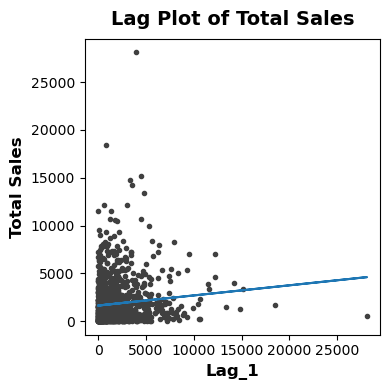

In [14]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Total Sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Total Sales');

The moving average is another way to look at the trend, and it is also similar.

In [15]:
moving_average = sales[['TotalSales']].rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

print("RMSE:",int(math.sqrt((abs(y - moving_average.squeeze())**2).sum())/X.shape[0]))

RMSE: 64


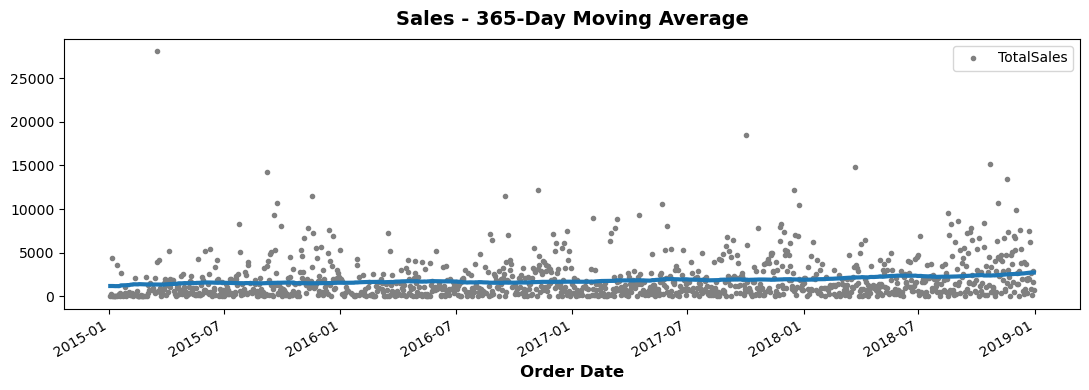

In [16]:
ax = sales[['TotalSales']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
);

Last, we'll look at setting up a deterministic process-- a linear regression line.  It should yield an identical result to our first use of the LinearRegression estimator.

In [17]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
X = dp.in_sample()
y = sales["TotalSales"]  # the target

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
print("RMSE:",int(math.sqrt((abs(y - y_pred)**2).sum())/X.shape[0]))

RMSE: 64


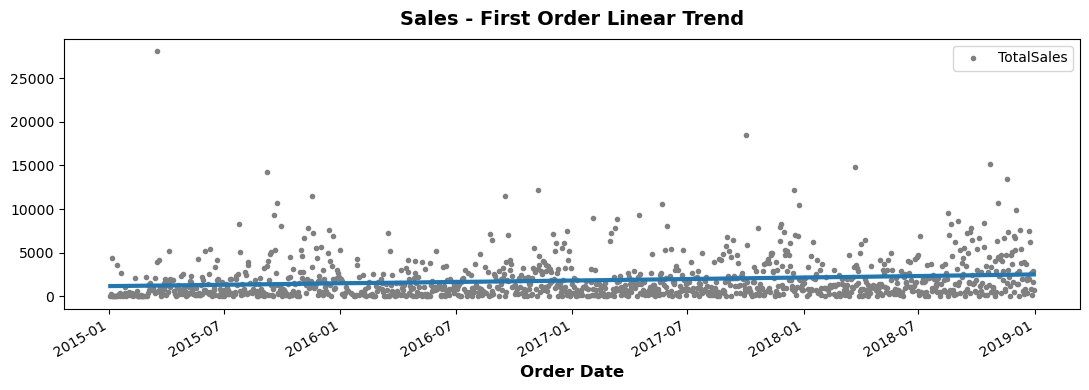

In [18]:
ax = sales[['TotalSales']].plot(style=".", color="0.5", title="Sales - First Order Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

We can also see about a second order trend line using the same process.

In [19]:
dp2 = DeterministicProcess(
    index=sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
X = dp2.in_sample()
y = sales["TotalSales"]  # the target

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
print("RMSE:",int(math.sqrt((abs(y - y_pred)**2).sum())/X.shape[0]))

RMSE: 64


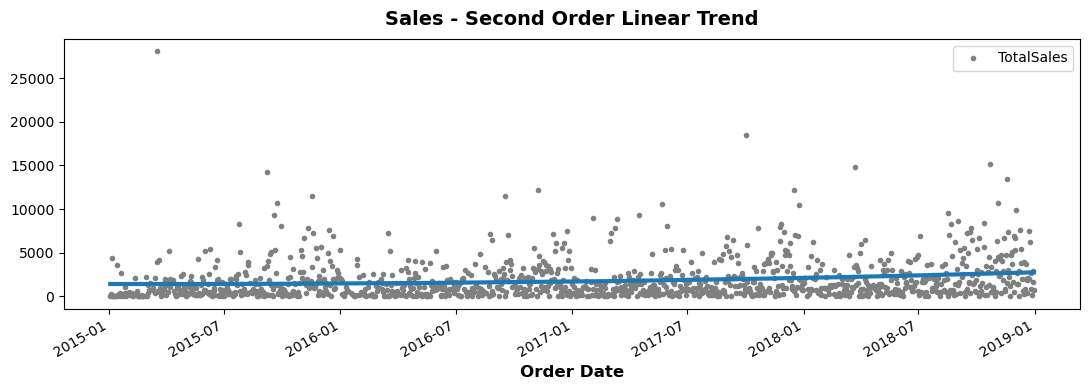

In [20]:
ax = sales[['TotalSales']].plot(style=".", color="0.5", title="Sales - Second Order Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

The difference in shape is hard to see on the graph, and there is minimal improvement in the RMSE.  The trend appears to be linear.

I'll use these functions for plotting.

In [21]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [22]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Looking at the Periodogram for the Total Sales, we find a few things:

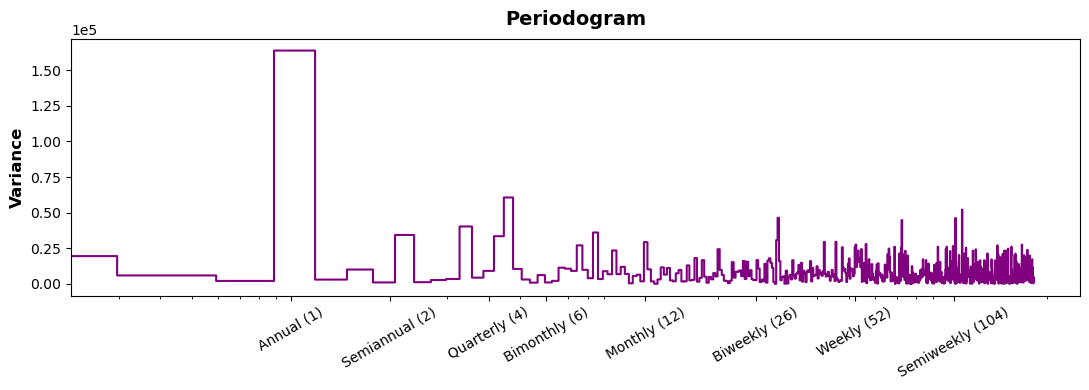

In [23]:
plot_periodogram(sales.TotalSales);

There is strong annual seasonality, and there are several hints at semiannual, quaterly, and other seasonal variations.  Unfortunatley, there is also a lot of noise around the shorter periods, so it will be tough to get a graet predictions from this data as residuals will likely appear fairly random.  Let's at least take a closer look at some of the periodicity that appears in the plot above.

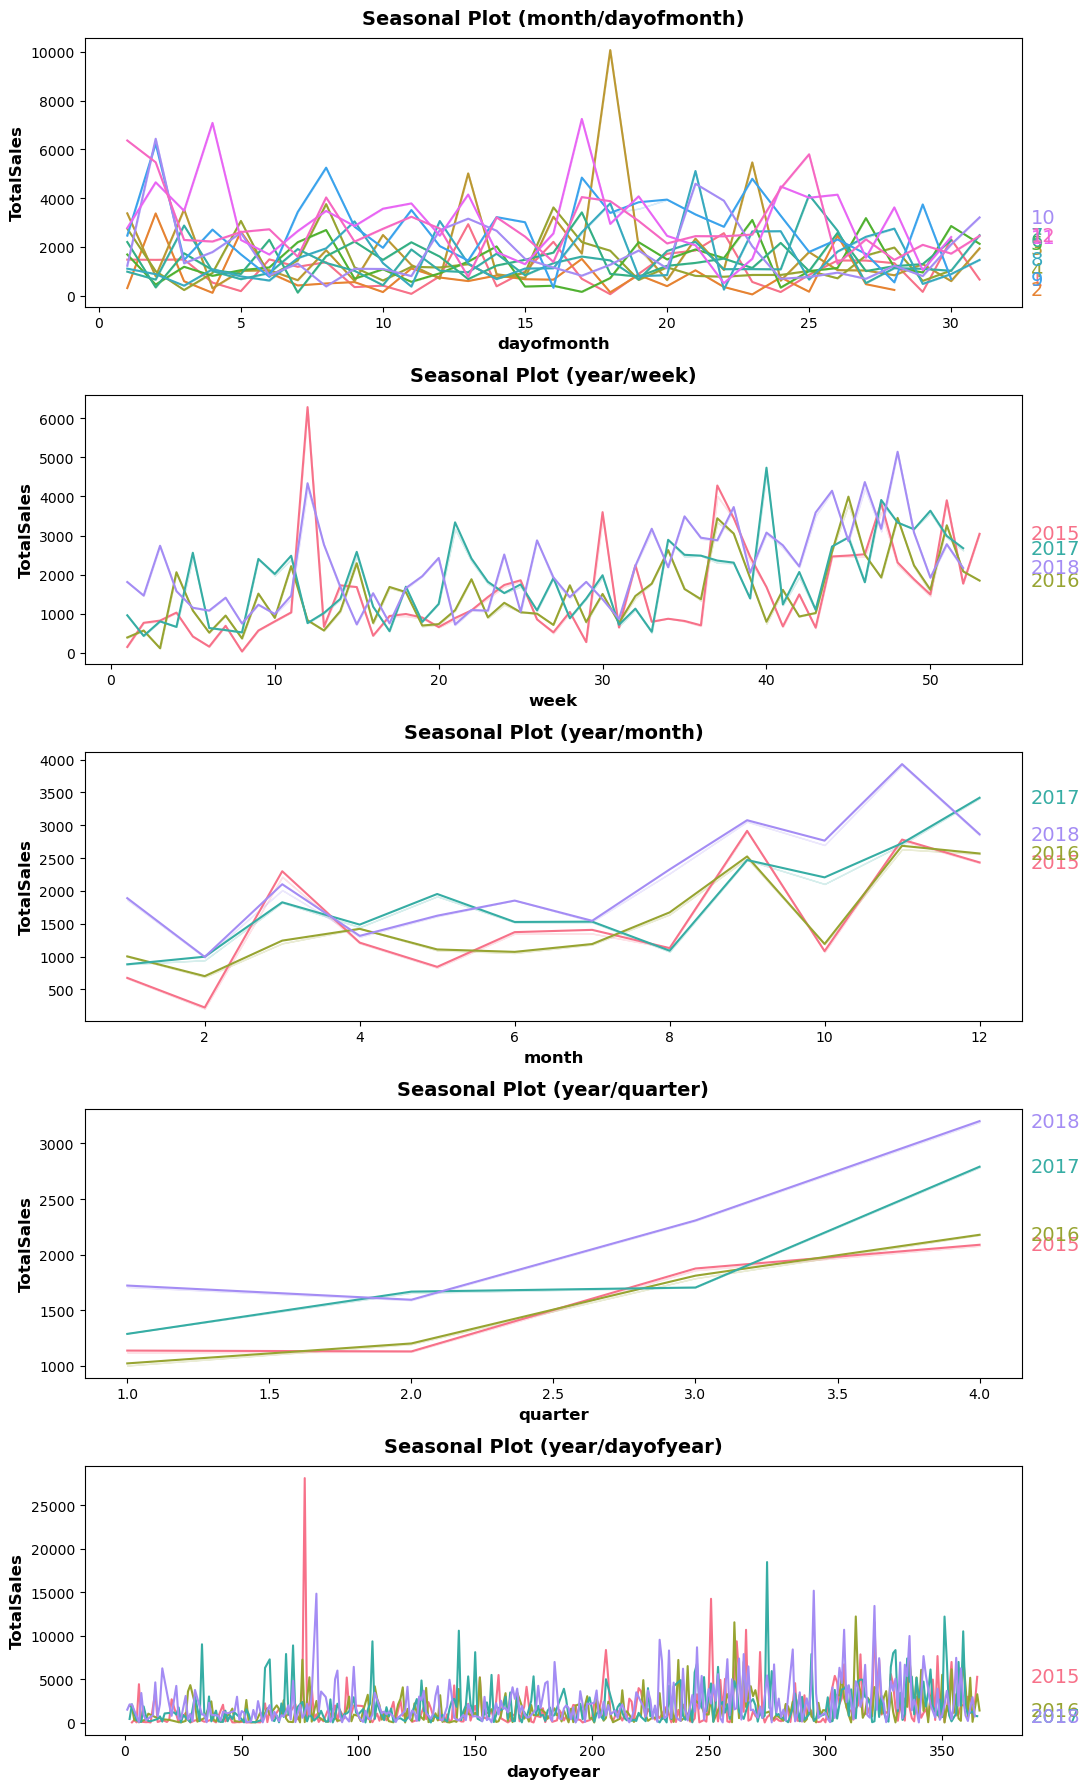

In [24]:
splot_df = sales.copy()
splot_df["dayofweek"] = splot_df.index.dayofweek
splot_df["dayofyear"] = splot_df.index.dayofyear
splot_df["dayofmonth"] = splot_df.index.day
splot_df["week"] = splot_df.index.week
splot_df["month"] = splot_df.index.month
splot_df["quarter"] = splot_df.index.quarter
splot_df["year"] = splot_df.index.year
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(11, 18))
seasonal_plot(splot_df, y="TotalSales", period="month", freq="dayofmonth", ax=ax0)
seasonal_plot(splot_df, y="TotalSales", period="year", freq="week", ax=ax1)
seasonal_plot(splot_df, y="TotalSales", period="year", freq="month", ax=ax2)
seasonal_plot(splot_df, y="TotalSales", period="year", freq="quarter", ax=ax3)
seasonal_plot(splot_df, y="TotalSales", period="year", freq="dayofyear", ax=ax4);

As expected, hard ot see any patterns in the daily data between years or months, but we definitely see annual seasonality in the periods of months, quarters, and to some extent the week.  We'll try to caputre some of this annual variation with fourier series and the weekly variation in the indicators of the seasonality-focused DeterministicProcess class.  

In [25]:
from statsmodels.tsa.deterministic import CalendarFourier

fourier = CalendarFourier(freq="A", order=8)

dp = DeterministicProcess(
    index=sales.index.to_period('D'),
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()
y = sales['TotalSales']
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=y.index)
X.head(1)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)"
Order Date,,,,,,,,,,,,,,,,,,,,,
2015-01-03,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.137279,0.990532,0.171293,0.98522,0.205104,0.97874,0.238673,0.9711,0.271958,0.962309


Let's plot the periodogram again as it was before and after we subtract out seasonality.

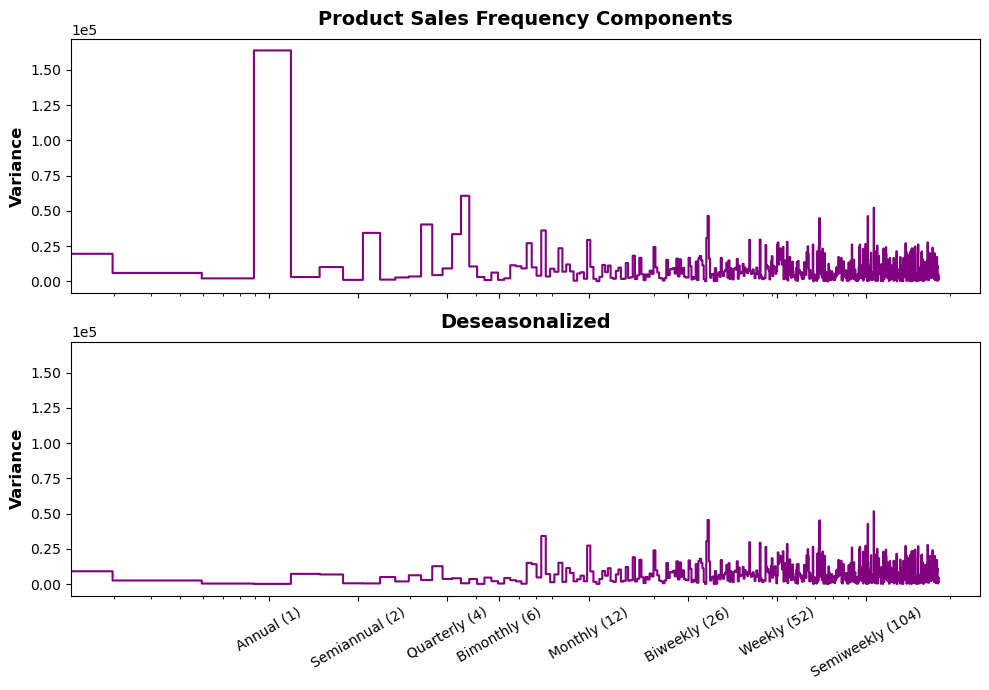

In [26]:
y_deseason = y - y_pred
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

We have reducted the large period seasonality, although we are left with a lot of waviness in the diagram above.  There is a lot of unseasonality to ordering, it seems.

Let's turn attention to the cyclical potential of this data.  We already added a Lag1, and we'll add a couple more to teh data.

In [27]:
sales['Lag_2'] = sales['TotalSales'].shift(2)
sales['Lag_3'] = sales['TotalSales'].shift(3)

Now let's define some Kaggle-provided plotting functions so we can see how the addiitonal lag features helps (or doesn't) in predictions.

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf

In [29]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [30]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

If we plot the data with 8 lags, we find in all cases, there is ver little "help" from these added features.  The correlation remains small across the board.  There is some contribution from the Lag1, and again around 6 and 7, likely due to the weekly periodic nature of business purchases, but none of these are very predictive, and adding them to our model isn't going to help.

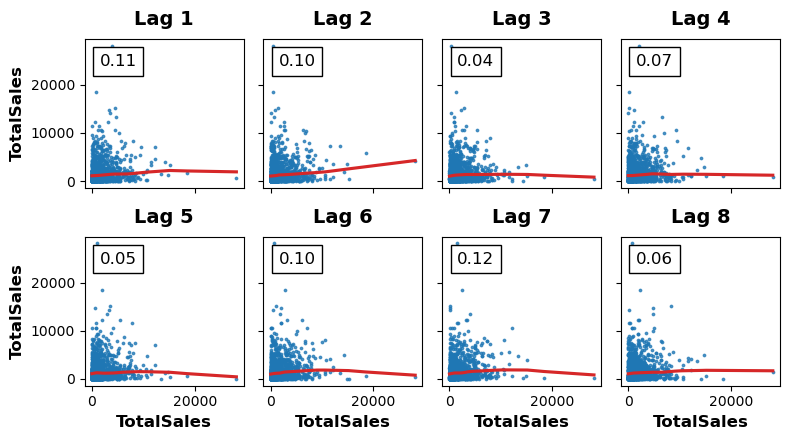

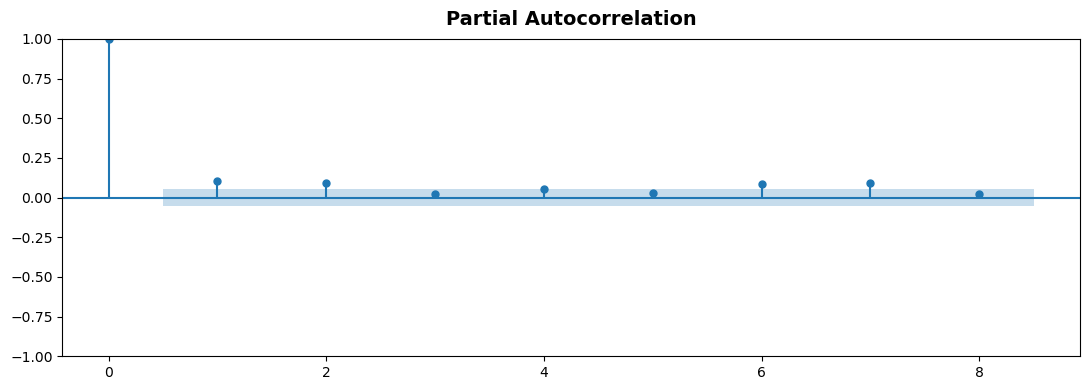

In [31]:
_ = plot_lags(sales['TotalSales'], lags=8, nrows=2)
_ = plot_pacf(sales['TotalSales'], lags=8)

Let's wrap this up by looking at the deseasonalized plot, which is esssentially our residual to the actual values.

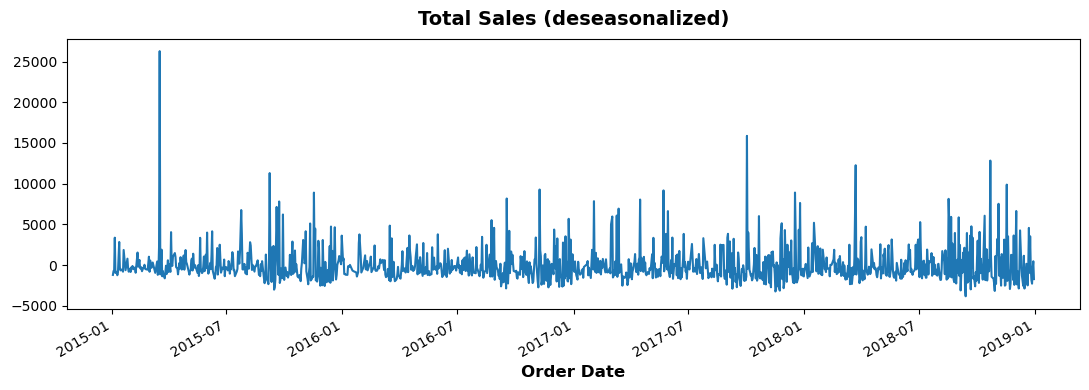

In [32]:
ax = y_deseason.plot()
ax.set_title("Total Sales (deseasonalized)");

Just to check, we can look to see if there is any cyclical contribution within this data we missed, and the plots show the same issues as before with teh full data.  This is expected, just nice to confirm.

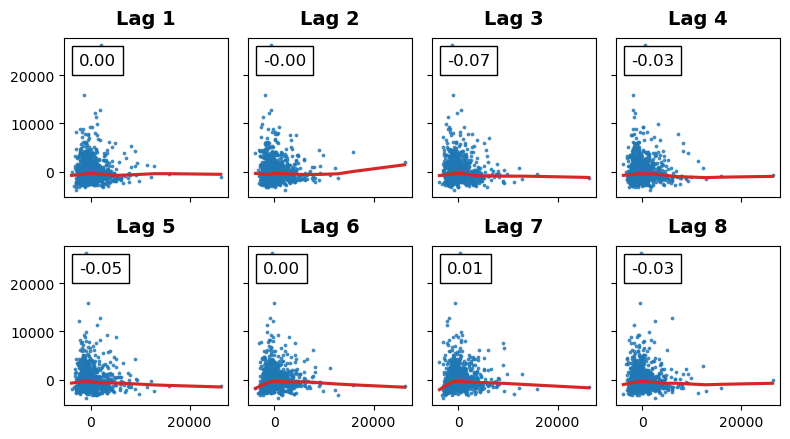

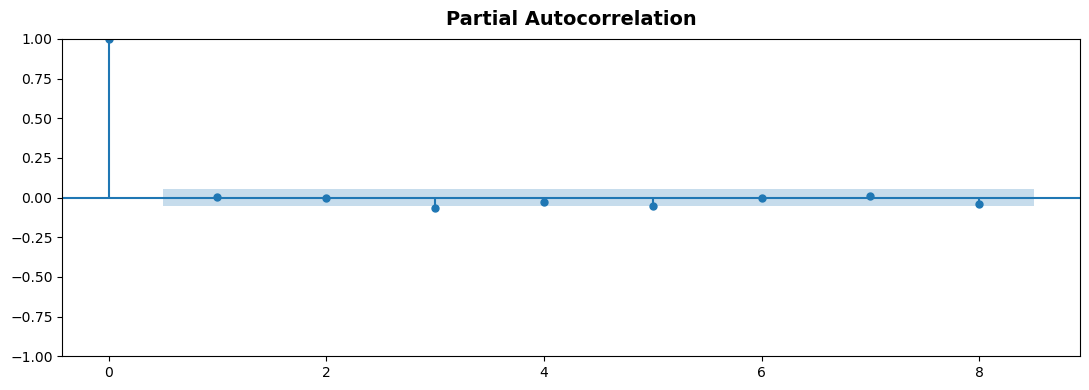

In [33]:
plot_lags(y_deseason, lags=8, nrows=2);
plot_pacf(y_deseason, lags=8);

The last step in our predictions is to take our features dataframe, fitted to the sales data, and apply this to an additional set of time steps.  We can then plot this out to see what it looks like.  Since the data is large and the visual indicators of the predictions get drowned a bit, we can use a second plot to look a bit closer.

In [34]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=7)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

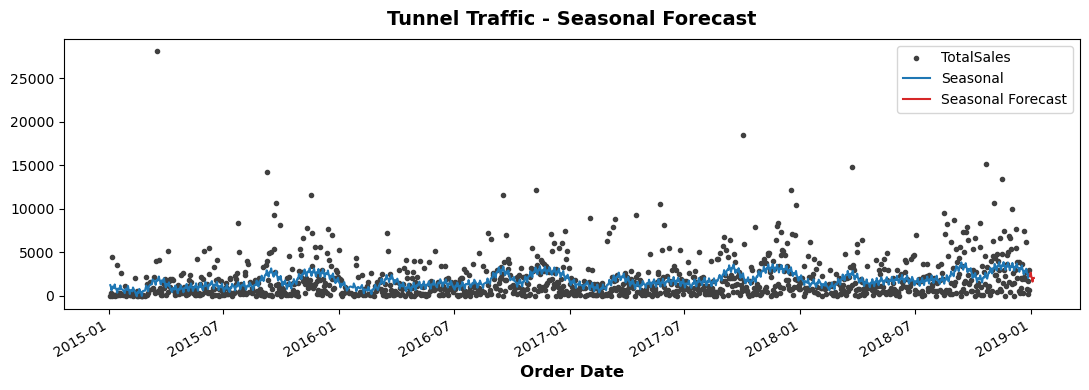

In [35]:
ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

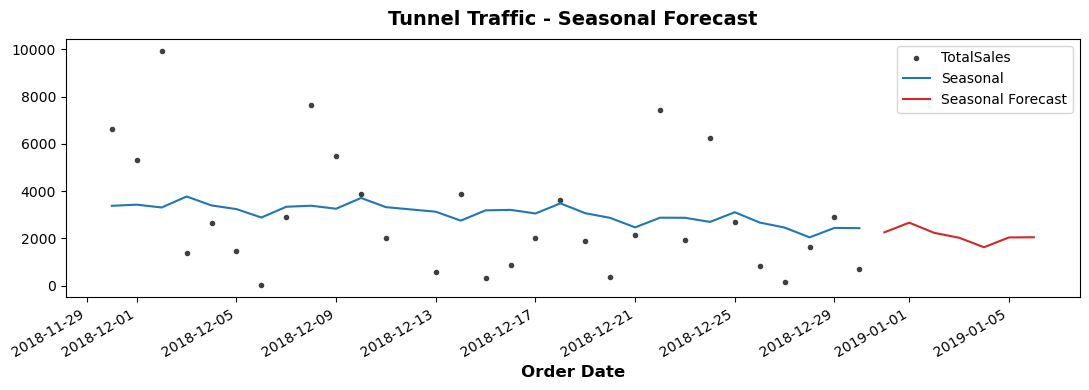

In [36]:
prox_idx = -30
ax = y[prox_idx::].plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred[prox_idx::].plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

And here are the actual predicted values, indexed to their future dates.

In [37]:
y_fore

2018-12-31    2259.859320
2019-01-01    2669.677932
2019-01-02    2238.179770
2019-01-03    2032.785682
2019-01-04    1629.548204
2019-01-05    2044.080616
2019-01-06    2051.277091
Freq: D, dtype: float64